In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.optim as optim
from torchvision import models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import copy
from PIL import Image

In [2]:
class BoysDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__ (self, index):

        image_name = self.annotations.iloc[index, 0] # first column of the csv file
                                                     # format i.e: class_name1_01.jpg
                                                     #             class_name1_02.jpg
        temp = image_name.split('.')
        for word in temp:
          folder_name = word
          break
        folder_name = folder_name[:-3]                # extract the class_name from image_name
        root_directory = os.path.join(self.root_dir, folder_name)

        image_path = os.path.join(root_directory, self.annotations.iloc[index, 0])
        image = Image.open(image_path).convert('RGB') # IMPORTANT! A usual image has an extra 'alpha' channel.
                                                      # image imported using PIL alr a PIL image, otherwise
                                                      # you have to set them in transforms!
        y_label = torch.tensor(self.annotations.iloc[index, 1])

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [3]:
train_csv_file = '/content/drive/MyDrive/boys_dataset_train.csv'
val_csv_file = '/content/drive/MyDrive/boys_dataset_val.csv'
train_dir = '/content/drive/MyDrive/boys_dataset/train'
val_dir = '/content/drive/MyDrive/boys_dataset/val'

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
trans1 = transforms.Compose([
                            #  transforms.ToPILImage(),
                             transforms.Resize((224, 224)),
                             transforms.RandomHorizontalFlip(p=0.5),
                             transforms.RandomAdjustSharpness(sharpness_factor=2),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

trans2 = transforms.Compose([
                            #  transforms.ToPILImage(),
                             transforms.Resize((224, 224)),
                             transforms.RandomPosterize(bits=2),
                             transforms.RandomAutocontrast(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
])

In [6]:
train_dataset = BoysDataset(csv_file = train_csv_file, root_dir = train_dir, transform = trans1)
val_dataset = BoysDataset(csv_file = val_csv_file, root_dir = val_dir, transform = trans2)

In [7]:
val_size = int(len(val_dataset) * 0.6)
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = torch.utils.data.random_split(dataset=val_dataset, lengths=[val_size, test_size])

In [9]:
batch_size = 3

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
model = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [12]:
for param in model.parameters():
  param.requires_grad = False

In [13]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
model = model.to(device)

In [16]:
path = '/content/drive/MyDrive/saved_ckpnt/checkpoint.pth'
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model'])
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [17]:
def visualize_cost (loss_train, loss_val, acc_train, acc_val):
    plt.figure(figsize=(10,7))
    plt.grid()
    if loss_train and loss_val:
      plt.plot(np.array(loss_train), label='train')
      plt.plot(np.array(loss_val), label='val')
      plt.ylabel('$Loss$', size=20)
    else:
      plt.plot(np.array(acc_train), label='train')
      plt.plot(np.array(acc_val), label='val')
      plt.ylabel('$Acc$', size=20)

    plt.xlabel('$Epochs$', size=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.show()

In [18]:
loss_cache_train = checkpoint['loss']
loss_cache_val = checkpoint['loss_val']
acc_cache_train = checkpoint['acc']
acc_cache_val = checkpoint['acc_val']

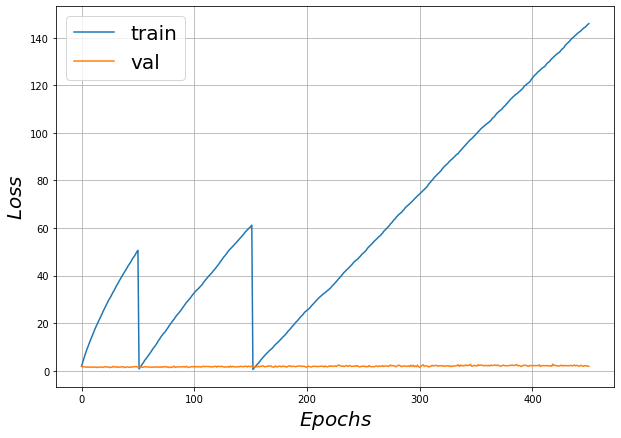

In [19]:
visualize_cost(loss_cache_train, loss_cache_val, None, None)

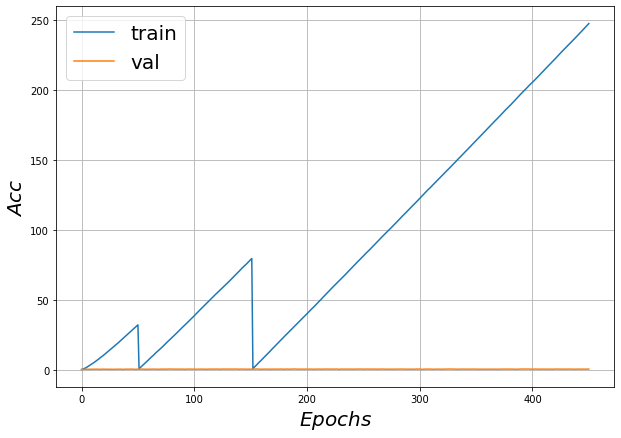

In [20]:
visualize_cost(None, None, acc_cache_train, acc_cache_val)

In [21]:
class_names = {
    0: 'timmy_xu',
    1: 'corbyn_besson',
    2: 'keita_machida',
    3: 'wang_kai',
    4: 'chau_minh_chi'
}

In [22]:
def visualize_model(model, num_images, loader, mean, std):
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for idx, (images, labels) in enumerate(loader):

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      for j in range(images.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        temp = index.cpu()
        temp2 = temp[j].numpy()
        ax.set_title(f'predicted: {class_names[int(temp2)]}')
        out = images.cpu().data[j]
        imshow(out, None, mean, std, transform=False)

        if images_so_far == num_images:
          return

In [24]:
# visualize tensor image
def imshow(image_batch, title, mean, std, transform=False):

  if transform is False:
    image_batch = image_batch.numpy().transpose(1,2,0)
    mean = np.array(mean)
    std = np.array(std)
    image_batch = image_batch * std + mean # unnormalize
    image_batch = np.clip(image_batch, 0, 1) # any values below 0 or above 1 is clipped
  else:
    image_batch = image_batch.numpy().transpose(1,2,0)
    image_batch = np.clip(image_batch, 0, 1)

  plt.imshow(image_batch)
  if title:
    plt.title(title)
    plt.axis('off')
  plt.pause(0.001)

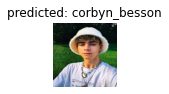

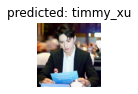

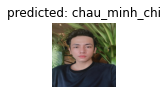

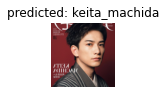

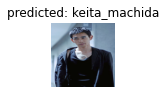

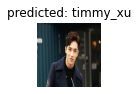

In [25]:
visualize_model(model, 6, train_loader, mean, std)

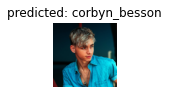

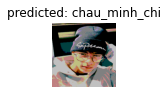

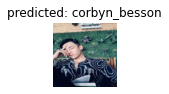

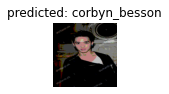

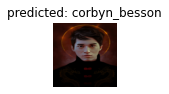

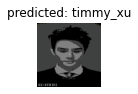

In [26]:
visualize_model(model, 6, val_loader, mean, std)

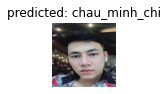

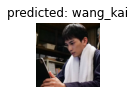

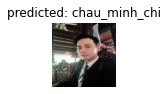

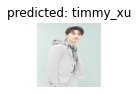

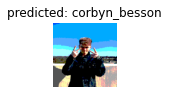

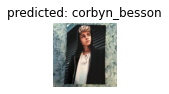

In [27]:
visualize_model(model, 6, test_loader, mean, std)

In [28]:
def predict(model, image_path):

  from PIL import Image
  raw_image = Image.open(image_path).convert('RGB')

  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]

  trans2 = transforms.Compose([
                            #  transforms.ToPILImage(),
                             transforms.Resize((224, 224)),
                             transforms.RandomPosterize(bits=2),
                             transforms.RandomAutocontrast(),
                             transforms.ToTensor(),
                             transforms.Normalize(mean, std)
  ])

  image = trans2(raw_image)
  image = image.unsqueeze(0)
  image = image.to('cuda')

  import torch
  model.eval()

  with torch.no_grad():

    y_predicted = model(image)
    _, index = torch.max(y_predicted, 1)

  pred = index.cpu().numpy()
  predicted_class = int(pred[0])

  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg

  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)

  classes = {
    0: 'timmy_xu',
    1: 'corbyn_besson',
    2: 'keita_machida',
    3: 'wang_kai',
    4: 'chau_minh_chi'
  }

  title = classes[predicted_class]
  plt.title(title, size=20)
  plt.axis('off')
  plt.show()

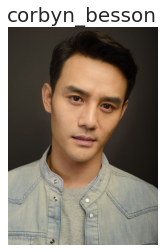

In [46]:
predict(model, '/content/179975.jpg')

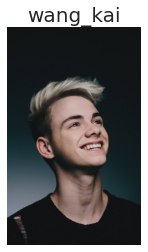

In [47]:
predict(model, '/content/301bbac13acdf4f59711321109833474.jpg')

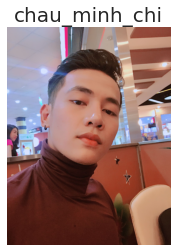

In [48]:
predict(model, '/content/46450829_1570950156338035_7240528899220701184_n.jpg')

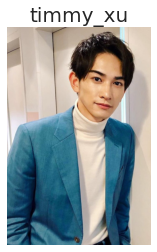

In [49]:
predict(model, '/content/Keita_Machida.jpg')

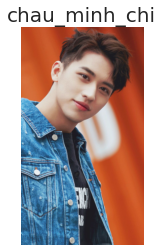

In [50]:
predict(model, '/content/df0e769832d7b64e3fc0c7a3c8c139e5--hair.jpg')

In [51]:
num_classes = 5

In [52]:
def check_accuracy(loader, loader_dataset, model):

  if loader == val_loader:
    print('Val Acc')
  elif loader == train_loader:
    print('Train Acc')
  else:
    print('Test Acc')

  running_corrects = 0
  num_samples = 0

  n_correct_class = [0 for i in range(num_classes)]
  n_class_samples = [0 for i in range(num_classes)]

  model.eval()

  with torch.no_grad():

    for images, labels in loader:

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      running_corrects += (index == labels.data).sum()

      temp_ = index.cpu().numpy()
      num_samples += temp_.shape[0]

      temp = labels.cpu().numpy()

      for i in range(temp.shape[0]):
        
        label = temp[i]
        index_i = temp_[i]

        if label == index_i:
          n_correct_class[label] += 1
        n_class_samples[label] += 1

    convert = running_corrects.double()
    acc = convert / len(loader_dataset)
    print(f'Got {int(convert.item())}/{num_samples} correct samples over {acc.item() * 100:.2f}%')

    classes = ['timmy_xu', 'corbyn_besson', 'keita_machida', 'wang_kai', 'chau_minh_chi']
    for i in range(num_classes):
      acc_ = 100 * n_correct_class[i] / n_class_samples[i]
      print(f'Accuracy of {classes[i]}: {acc_:.2f}%')

In [37]:
check_accuracy(val_loader, val_dataset, model)

Val Acc
Got 19/44 correct samples over 43.18%
Accuracy of timmy_xu: 11.11%
Accuracy of corbyn_besson: 77.78%
Accuracy of keita_machida: 14.29%
Accuracy of wang_kai: 36.36%
Accuracy of chau_minh_chi: 75.00%


In [38]:
check_accuracy(test_loader, test_dataset, model)

Test Acc
Got 12/30 correct samples over 40.00%
Accuracy of timmy_xu: 40.00%
Accuracy of corbyn_besson: 66.67%
Accuracy of keita_machida: 12.50%
Accuracy of wang_kai: 0.00%
Accuracy of chau_minh_chi: 71.43%


In [39]:
check_accuracy(train_loader, train_dataset, model)

Train Acc
Got 99/99 correct samples over 100.00%
Accuracy of timmy_xu: 100.00%
Accuracy of corbyn_besson: 100.00%
Accuracy of keita_machida: 100.00%
Accuracy of wang_kai: 100.00%
Accuracy of chau_minh_chi: 100.00%


In [40]:
def predict_array(model, loader):

  targets = []
  preds = []

  model.eval()
  with torch.no_grad():

    for images, labels in loader:

      label = labels.numpy()
      for item in label:
        targets.append(item)

      images = images.to(device)
      labels = labels.to(device)

      y_predicted = model(images)
      _, index = torch.max(y_predicted, 1)

      index_ = index.detach().cpu().numpy()
      for item in index_:
        preds.append(item)

  return targets, preds

In [41]:
def report_accuracy(targets, preds):
  from sklearn.metrics import classification_report, confusion_matrix
  print(classification_report(targets, preds))

  import seaborn as sn
  import matplotlib.pyplot as plt
  import numpy as np

  cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
  index = np.random.randint(0, len(cmap_list))

  labels = ['timmy_xu', 'corbyn_besson', 'keita_machida', 'wang_kai', 'chau_minh_chi']

  import pandas as pd
  cm = confusion_matrix(targets, preds)
  df_cm = pd.DataFrame(cm, labels, labels)
  sn.heatmap(df_cm, annot_kws={"size": 16}, annot=True, cmap=cmap_list[index], fmt = 'g')
  sn.set(font_scale=1.4)
  plt.title('Confusion Matrix')
  plt.ylabel('Correct-label', fontsize=20)
  plt.xlabel('Predicted-label', fontsize=20)
  plt.show()

In [42]:
y_true, y_pred = predict_array(model, train_loader)
y_true1, y_pred1 = predict_array(model, val_loader)
y_true2, y_pred2 = predict_array(model, test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



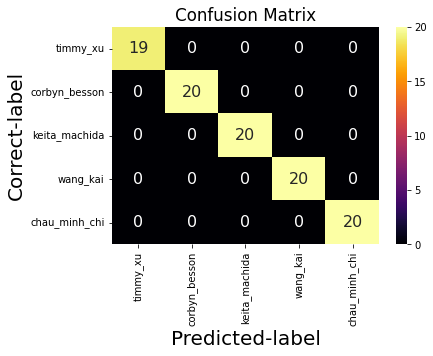

In [43]:
report_accuracy(y_true, y_pred) # on the train loader

              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.40      0.89      0.55         9
           2       0.20      0.14      0.17         7
           3       1.00      0.45      0.62        11
           4       0.78      0.88      0.82         8

    accuracy                           0.52        44
   macro avg       0.56      0.52      0.49        44
weighted avg       0.59      0.52      0.50        44



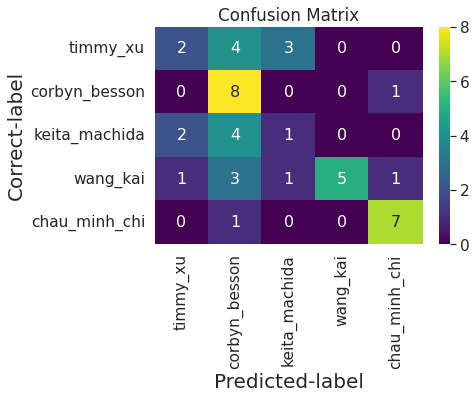

In [44]:
report_accuracy(y_true1, y_pred1) # on the validation loader

              precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.44      0.67      0.53         6
           2       0.25      0.12      0.17         8
           3       0.25      0.25      0.25         4
           4       0.67      0.57      0.62         7

    accuracy                           0.40        30
   macro avg       0.38      0.40      0.38        30
weighted avg       0.39      0.40      0.38        30



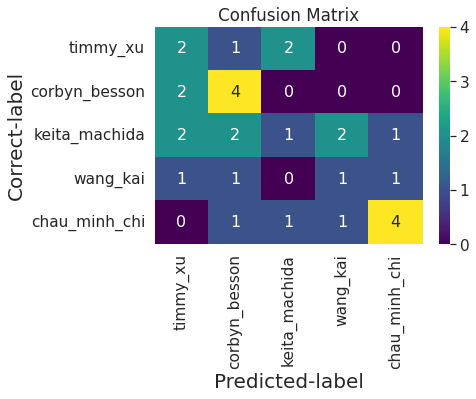

In [45]:
report_accuracy(y_true2, y_pred2) # on the test loader